# Lab 2: Data exploration

In HW1, we did some basic data exploration and visualization. In this lab, we will continue digging through the 311 datasets for more data wrangling practice. Specifically, we'll focus on geographical visualizations.

To start we'll need to install the following python libraries:
- geopandas
- folium

Install them with pip/conda:

<code>pip install geopandas
pip install folium
</code>

In [236]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

As you've probably noticed while doing your homework, different neighborhoods/zipcodes have different distributions of 311 requests. We will attempt to visualize these differences.

Before we start, we'll need an the boundaries of the Chicago zipcodes, which we can get from: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-ZIP-Codes/gdcf-axmw

First let's load our datasets and the zipcode geojson.

In [242]:
# You should load as many of them as you want. For
size = 20000
rodent_df = pd.read_csv('data/311_rodent.csv', nrows=size)
vac_df = pd.read_csv('data/311_vacant.csv', nrows=size)
geo_df = gpd.read_file('data/chi_boundaries.geojson')

In [243]:
# Some preprocessing
vac_df.drop(columns=['IS THE BUILDING DANGEROUS OR HAZARDOUS?'], inplace=True)
vac_df.dropna(inplace=True)
rod_df.dropna(inplace=True)
vac_df['zip'] = vac_df['ZIP CODE'].astype(int)
rod_df['zip'] = rod_df['ZIP Code'].astype(int)
geo_df['zip'] = geo_df['zip'].astype(int)

## Choropleth Maps with geopandas
geopandas.read_file takes in a geojson file and creates a GeoDataFrame. You can read more about it from the [geopandas api](http://geopandas.org/data_structures.html). The GeoDataFrame can then be plotted right off the bat:

In [250]:
geo_df.head()

,objectid,shape_len,zip,shape_area,geometry
0,33,42720.0444058,60647,106052287.488,(POLYGON ((-87.67762151065281 41.9177578010629...
1,34,48103.7827213,60639,127476050.762,(POLYGON ((-87.72683253163021 41.9226462671259...
2,35,27288.6096123,60707,45069038.4783,(POLYGON ((-87.78500237831095 41.9091478547167...
3,36,42527.9896789,60622,70853834.3797,(POLYGON ((-87.6670686895295 41.88885188496992...
4,37,47970.1401531,60651,99039621.2518,(POLYGON ((-87.70655631674127 41.8955534069940...


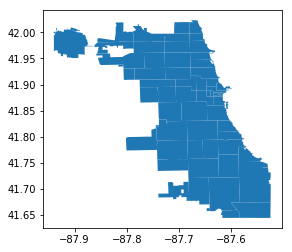

In [251]:
geo_df.plot()

This is not too interesting so let's try to make the plot tell us something about each of the zipcodes. We can do this by setting the column parameter which will then shade the zipcode block according to that column. You can supply a [matplotlib colormap](https://matplotlib.org/examples/color/colormaps_reference.html) string for the cmap parameter for different types of color gradients.

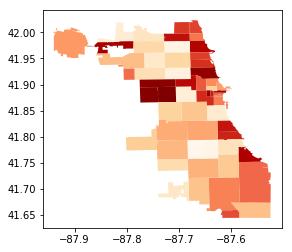

In [255]:
geo_df.plot(column='shape_area', cmap='OrRd')

Now, let's augment this geoDataFrame with a new column for the number of 311 requests of rodent complaints to see something a bit more interesting. To do this we'll create a dataframe for the number of 311 requests that each zipcode received in aggregate, and merge this to geo_df

In [265]:
# Get the counts
rod_zip_counts = rod_df.groupby('zip').count()
vac_zip_counts = vac_df.groupby('zip').count()
# Make a smaller dataframe with two columns: "zip" and "count"
r_zipcounts = pd.DataFrame({'zip': rod_zip_counts.index, 'count': rod_zip_counts['Status']})
v_zipcounts = pd.DataFrame({'zip': vac_zip_counts.index, 'count': vac_zip_counts['Ward']})
print(r_zipcounts.head())
print(v_zipcounts.head())

       count    zip
zip                
60601      5  60601
60602      1  60602
60603      3  60603
60604      4  60604
60605     16  60605
       count    zip
zip                
60601      1  60601
60605      8  60605
60607      8  60607
60608     82  60608
60609    370  60609


In [270]:
# Join them onto geo_df
rjoined = geo_df.join(r_zipcounts, on='zip', how='left', lsuffix='l', rsuffix='r')
vjoined = geo_df.join(v_zipcounts, on='zip', how='left', lsuffix='l', rsuffix='r')
# There is probably a cleaner way to do this, but I'll let you figure that out.

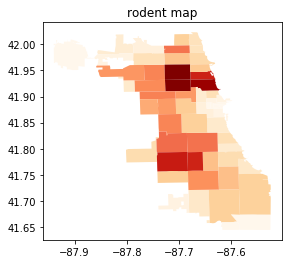

In [267]:
# Plot the map color coded by number of rodent 311 requests
rjoined.plot(column='count', cmap='OrRd')
plt.title('rodent map')
plt.show()

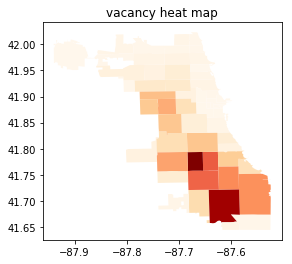

In [268]:
# Plot the map color coded by number of vacancy calls
vjoined.plot(column='count', cmap='OrRd')
plt.title('vacancy heat map')
plt.show()

## Heatmaps with folium

While these visualizations are useful in summarizing where we might expect more rodent/vacancy/etc requests to come from, they're a bit coarse because zipcode blocks can be pretty big. To get a finer grained view of where these requests happen, we'll learn how to plot a heatmap of these 311 requests using folium.

Recall that our 311 data contains the latitude and longitude of these values.

In [219]:
rod_xy = rod_df[['Latitude', 'Longitude']]
vac_xy = vac_df[['LATITUDE', 'LONGITUDE']]

In [274]:
import folium
from folium.plugins import HeatMap

In [276]:
print(rod_xy.mean())
print(vac_xy.mean())

Latitude     41.874600
Longitude   -87.689872
dtype: float64
LATITUDE     41.787841
LONGITUDE   -87.661079
dtype: float64


In [280]:
hmap = folium.Map(location=[41.87, -87.69], zoom_start=10)
hm_rod = HeatMap(zip(rod_xy['Latitude'].values, rod_xy['Longitude'].values), radius=13, blur=20)
hmap.add_child(hm_rod)

In [284]:
hmap = folium.Map(location=[41.87, -87.69], zoom_start=10, )
hm_rod = HeatMap(zip(vac_xy['LATITUDE'].values, vac_xy['LONGITUDE'].values), radius=14, blur=20)
hmap.add_child(hm_rod)

Play around with the zoom_start, radius and blur parameters to get a better sense of how they affect the resulting visualizations.

# Excercises:
Now that we've seen how to create some simple geographical visualizations you should aggregate the 311 requests by zipcode and visualize request frequency, average request completion time by location, and any other things you find interesting. Some specific questions that might be good to explore:

- Do certain neighborhoods get preferential treatment(in terms of completion time of 311 requests)?

- How do median household incomes differ by neighborhood?

### References
http://pandas.pydata.org/pandas-docs/stable/timeseries.html

http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html

http://geopandas.org/mapping.html

http://geopandas.org/mergingdata.html

http://python-visualization.github.io/folium/docs-v0.5.0/index.html

### Examples
http://blog.yhat.com/posts/interactive-geospatial-analysis.html

https://alcidanalytics.com/p/geographic-heatmap-in-python